# **Import potřebných knihoven a určení barevného spektra**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import json
import csv
import datetime as dt

import warnings

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import kruskal
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

from numpy import mean
from numpy import std

from typing import List

In [2]:
import seaborn as sns
sns.set(style="ticks")
sns.set_color_codes("colorblind")
sns.set(style="darkgrid")

In [3]:
import warnings
warnings.filterwarnings('ignore')

Určení barevného spektra

In [4]:
color = [
'#000000',
'#000080',
'#0B0BFF',
'#98B5FF', 
'#BBC9DB',
'#797975',
'#0198E1',
'#00688B',
'#74CDDC', #nej
'#05EDFF',  
'#C9FFFF', 
'#8FBCBC',
'#457371',
'#28AE7B',
'#4DFFA5'
]

# **Načtení souborů, úprava sloupečků, datových typů a rozdělení data setu**

In [5]:
soubor = pd.read_csv('final.csv', encoding='utf-8', low_memory=False)

Změna datového typu

In [6]:
soubor['TIMETABLE_ARRIVAL_TIME'] = pd.to_datetime(soubor['TIMETABLE_ARRIVAL_TIME']).dt.time

In [7]:
soubor['ORIGIN_TIMESTAMP'] = pd.to_datetime(soubor['ORIGIN_TIMESTAMP']).dt.time

In [8]:
soubor['START_TIME'] = pd.to_datetime(soubor['START_TIME']).dt.time

Vytvoření nového sloupce pouze s údajem, ve které hodině autobus jel

In [9]:
for i, x in enumerate(soubor['ORIGIN_TIMESTAMP']):
    hour = x.hour
    soubor.loc[i,'HOUR'] = hour

Selekce pouze dní v týdnu/víkendu a období během koronaviru a ,,po něm"

In [10]:
inside_covid = soubor[(soubor['DATE'] <= '2020-05-17') & (~soubor['DAY_OF_WEEK'].isin(['Saturday','Sunday']))]

In [11]:
len(inside_covid['UNICORN'].unique())

178

In [12]:
after_covid_week = soubor[(soubor['DATE'] >= '2020-05-18') & (~soubor['DAY_OF_WEEK'].isin(['Saturday','Sunday']))]

In [13]:
len(after_covid_week['UNICORN'].unique())

112

In [14]:
after_covid_wknd = soubor[(soubor['DATE'] >= '2020-05-18') & (soubor['DAY_OF_WEEK'].isin(['Saturday','Sunday']))]

In [15]:
len(after_covid_wknd['UNICORN'].unique())

26

In [16]:
after_covid_full = soubor[soubor['DATE'] >= '2020-05-18']

In [17]:
len(after_covid_full['UNICORN'].unique())

138

# **Pohled na data na úrovni zkoumaného časového období (6-11 hodin dopoledne) během pracovního týdne**

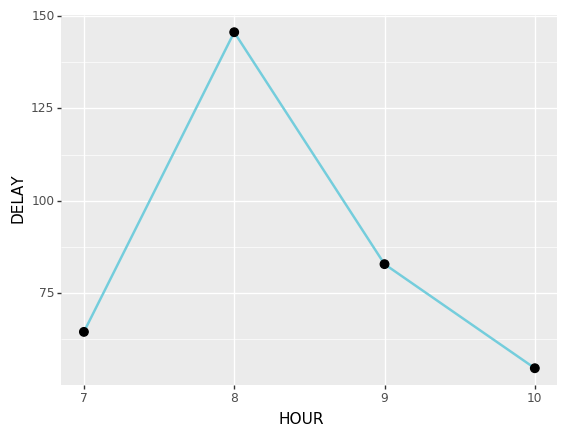

<ggplot: (-9223371921866743820)>

In [18]:
avg_delay_day = after_covid_week.groupby(['HOUR'])[['DELAY']].mean()
avg_delay_day = avg_delay_day.reset_index()

plot_delay_day = ggplot(avg_delay_day, aes(x='HOUR', y='DELAY')) + \
                    geom_line(color='#74CDDC',size=1) + \
                    geom_point(size=3) + \
                    scale_x_continuous(breaks=range(5, 13), minor_breaks=[]) + \
                    xlab("HOUR") + \
                    ylab("DELAY")
plot_delay_day

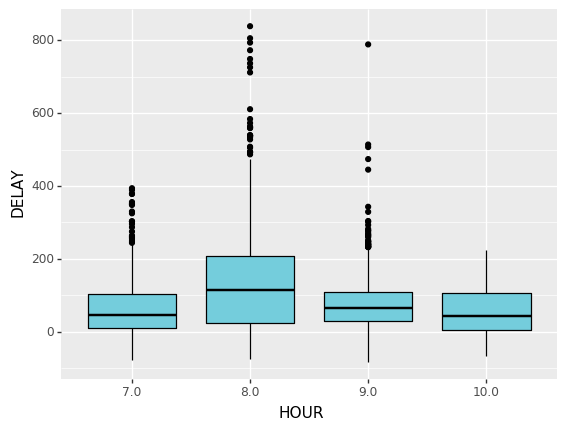

<ggplot: (-9223371921865745464)>

In [19]:
after_covid_week['HOUR_cat'] = after_covid_week['HOUR'].astype('category')

plotbox_delay_day = ggplot(after_covid_week, aes(x='HOUR_cat', y='DELAY')) + \
            geom_boxplot(color='black', fill='#74CDDC') + \
            xlab("HOUR") + \
            ylab("DELAY")
plotbox_delay_day

In [20]:
after_covid_week.groupby('HOUR')['DELAY'].describe()

,count,mean,std,min,25%,50%,75%,max
HOUR,,,,,,,,
7.0,555.0,64.556757,82.749338,-78.0,10.50,46.0,103.5,394.0
8.0,572.0,145.594406,155.127832,-74.0,24.75,115.0,209.0,839.0
9.0,437.0,82.874142,91.319558,-84.0,29.00,64.0,109.0,789.0
10.0,116.0,54.732759,65.280047,-68.0,3.75,42.0,106.0,224.0


### **Závěr: nějvětší zpoždění kolem 8. hodiny -> upravení datasetu pouze na tento úsek**

In [21]:
t1 = dt.time(7,30,0)
t2 = dt.time(9,0,0)

In [22]:
bebe = after_covid_week[ (after_covid_week['ORIGIN_TIMESTAMP']>=t1) & (after_covid_week['ORIGIN_TIMESTAMP']<=t2) ]

Populace = statistické údaje pro dataset zúžený na kratší časové období a pracovní týden, data k metrice Actual Delay

In [23]:
bebe['DELAY'].describe()

count    887.000000
mean     121.615558
std      139.674557
min      -74.000000
25%       22.000000
50%       82.000000
75%      189.000000
max      839.000000
Name: DELAY, dtype: float64

# **Test normality rozdělení**

zdroj: *https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/*

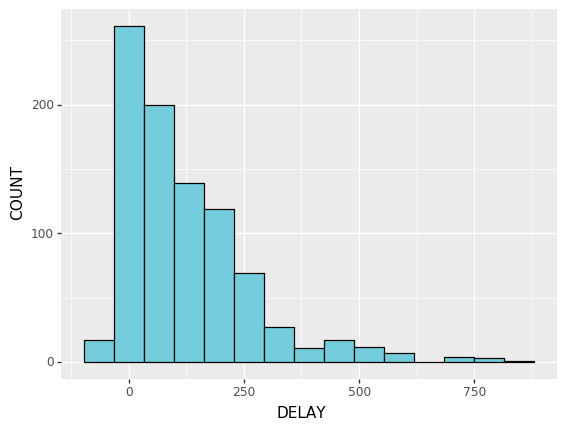

<ggplot: (-9223371921865645028)>

In [24]:
plot_hist1 = ggplot(bebe, aes(x='DELAY')) + \
            geom_histogram(color='black', fill='#74CDDC', bins=15) + \
            xlab("DELAY") + \
            ylab("COUNT")

plot_hist1

In [121]:
stat, p = shapiro(bebe['DIFF_DELAY'])
print(f'Statistics={stat}, p={round(p,5)}')

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.8699530363082886, p=0.0
Sample does not look Gaussian (reject H0)


### Závěr: data nejsou normálně rozdělena

# **Grafy závislosti zpoždění na zastávkách**

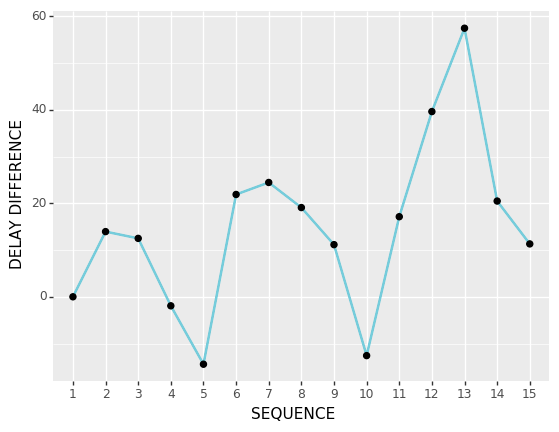

<ggplot: (-9223371921865031636)>

In [26]:
avg_delay_for_stop = bebe.groupby(['SEQUENCE'])[['DIFF_DELAY']].mean()
avg_delay_for_stop = avg_delay_for_stop.reset_index()

plot_poin_delay_stop = ggplot(avg_delay_for_stop, aes(x='SEQUENCE', y='DIFF_DELAY')) + \
    geom_point() + \
    geom_line() + \
    geom_line(color='#74CDDC',size=1) + \
    geom_point(size=2) + \
    scale_x_discrete(limits=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)) + \
    xlab("SEQUENCE") + \
    ylab("DELAY DIFFERENCE")
plot_poin_delay_stop

#### Závislost zpoždění z předchozí zastávky na rozdílu zpoždění

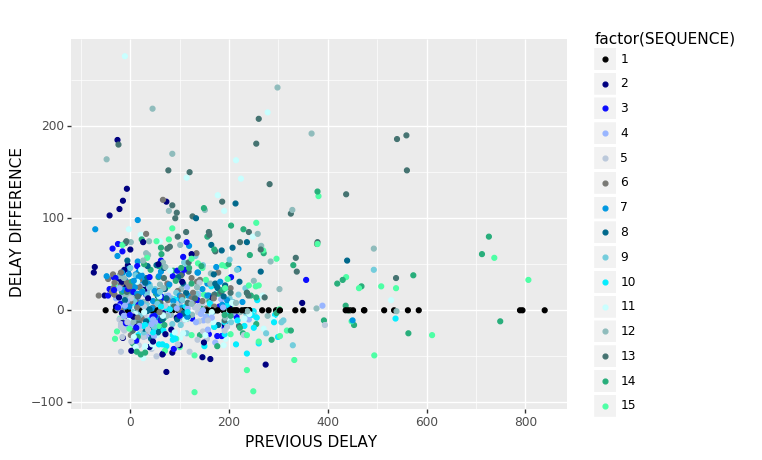

<ggplot: (-9223371921865093140)>

In [27]:
plot_point1 = ggplot(bebe,(aes(x='PREV_DELAY', y='DIFF_DELAY',color = 'factor(SEQUENCE)'))) + \
        scale_color_manual(values=color) + \
        geom_point() + \
        xlab("PREVIOUS DELAY") + \
        ylab("DELAY DIFFERENCE")
plot_point1

#### Závislost zpoždění z předchozí zastávky na rozdílu ve zpoždění na úrovni jednotlivých zastávek 


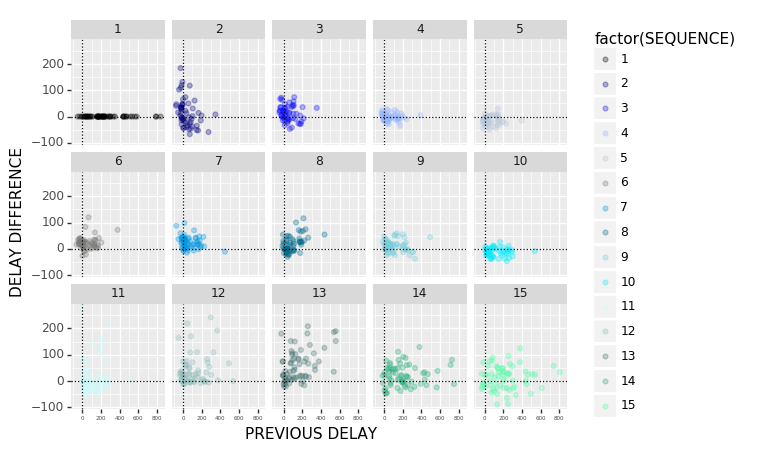

<ggplot: (-9223371921863678296)>

In [28]:
plot_point2 = ggplot(bebe, aes(x='PREV_DELAY', y='DIFF_DELAY', color = 'factor(SEQUENCE)' )) + \
        geom_point(alpha=0.3) + \
        geom_hline(yintercept=0,linetype='dotted') + \
        geom_vline(xintercept=0,linetype='dotted') + \
        theme(axis_text_x = element_text(size=4)) + \
        facet_wrap(['SEQUENCE'], nrow=3) + \
        scale_color_manual(values=color) + \
        xlab("PREVIOUS DELAY") + \
        ylab("DELAY DIFFERENCE")
plot_point2

Na zastávce číslo 2 a od zastávky č. 11 je vidět vychýlení od ostatních

#### Boxplot rozdílu zpoždění na jednotlivé zastávky

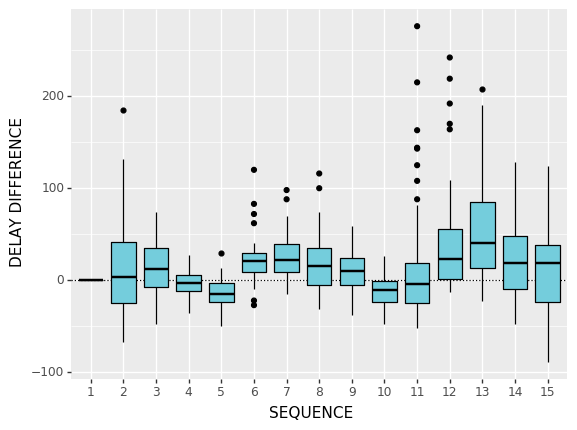

<ggplot: (-9223371921863472952)>

In [29]:
bebe['SEQUENCE_cat'] = bebe['SEQUENCE'].astype('category')

plot_box1 = ggplot(bebe, aes(x='SEQUENCE_cat', y='DIFF_DELAY')) + \
            geom_hline(yintercept=0,linetype='dotted') + \
            geom_boxplot(color='black', fill='#74CDDC') + \
            xlab("SEQUENCE") + \
            ylab("DELAY DIFFERENCE")
plot_box1

### **Kruskal-Wallis H-test**

zdroj: *https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/*

In [30]:
def specify_seq(data: pd.DataFrame, num_seq: int):
    new_df = data[data['SEQUENCE']==num_seq]['DIFF_DELAY']
    return new_df

In [31]:
print(f'For sequence 2: mean={round(mean(specify_seq(bebe,2)),4)}, std={round(std(specify_seq(bebe,2)),4)}')
print(f'For sequence 3: mean={round(mean(specify_seq(bebe,3)),4)}, std={round(std(specify_seq(bebe,3)),4)}')
print(f'For sequence 4: mean={round(mean(specify_seq(bebe,4)),4)}, std={round(std(specify_seq(bebe,4)),4)}')
print(f'For sequence 5: mean={round(mean(specify_seq(bebe,5)),4)}, std={round(std(specify_seq(bebe,5)),4)}')
print(f'For sequence 6: mean={round(mean(specify_seq(bebe,6)),4)}, std={round(std(specify_seq(bebe,6)),4)}')
print(f'For sequence 7: mean={round(mean(specify_seq(bebe,7)),4)}, std={round(std(specify_seq(bebe,7)),4)}')
print(f'For sequence 8: mean={round(mean(specify_seq(bebe,8)),4)}, std={round(std(specify_seq(bebe,8)),4)}')
print(f'For sequence 9: mean={round(mean(specify_seq(bebe,9)),4)}, std={round(std(specify_seq(bebe,9)),4)}')
print(f'For sequence 10: mean={round(mean(specify_seq(bebe,10)),4)}, std={round(std(specify_seq(bebe,10)),4)}')
print(f'For sequence 11: mean={round(mean(specify_seq(bebe,11)),4)}, std={round(std(specify_seq(bebe,11)),4)}')
print(f'For sequence 12: mean={round(mean(specify_seq(bebe,12)),4)}, std={round(std(specify_seq(bebe,12)),4)}')
print(f'For sequence 13: mean={round(mean(specify_seq(bebe,13)),4)}, std={round(std(specify_seq(bebe,13)),4)}')
print(f'For sequence 14: mean={round(mean(specify_seq(bebe,14)),4)}, std={round(std(specify_seq(bebe,14)),4)}')
print(f'For sequence 15: mean={round(mean(specify_seq(bebe,15)),4)}, std={round(std(specify_seq(bebe,15)),4)}')

For sequence 2: mean=13.9464, std=52.8189
For sequence 3: mean=12.5, std=29.167
For sequence 4: mean=-1.9286, std=13.6406
For sequence 5: mean=-14.4182, std=16.167
For sequence 6: mean=21.8909, std=23.3913
For sequence 7: mean=24.459, std=22.3516
For sequence 8: mean=19.0893, std=31.1301
For sequence 9: mean=11.1579, std=22.218
For sequence 10: mean=-12.5789, std=15.6888
For sequence 11: mean=17.1356, std=65.8513
For sequence 12: mean=39.625, std=55.7518
For sequence 13: mean=57.4545, std=59.0347
For sequence 14: mean=20.4853, std=39.4094
For sequence 15: mean=11.3125, std=44.3529


Porovnání rozdělení zastávek mezi sebou

In [32]:
stat, p = kruskal(specify_seq(bebe,2),specify_seq(bebe,3),specify_seq(bebe,4),specify_seq(bebe,5),
                  specify_seq(bebe,6),specify_seq(bebe,7),specify_seq(bebe,8),specify_seq(bebe,9),
                  specify_seq(bebe,10),specify_seq(bebe,11),specify_seq(bebe,12),specify_seq(bebe,13),
                  specify_seq(bebe,14),specify_seq(bebe,15))
print(f'Statistics={stat}, p={p}')
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=178.5005886761958, p=3.4317414087858796e-31
Different distributions (reject H0)


### **Závěr: na jednotlivých zastávkách se zpoždění chová jinak**

# **Grafy závislosti zpoždění na dnech**

Dataset po koronavirovém období, celý týden i s víkendem v daný časový úsek (7:30 - 9 hodin)

In [33]:
full_week = after_covid_full[ (after_covid_full['ORIGIN_TIMESTAMP']>=t1) & (after_covid_full['ORIGIN_TIMESTAMP']<=t2) ]

In [34]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday']
full_week['DAY_OF_WEEK'] = pd.Categorical(full_week['DAY_OF_WEEK'], days)
full_week.sort_values('DAY_OF_WEEK')

,TRIP_ID,ROUTE,DAY_OF_WEEK,DATE,UNICORN,START_TIME,HEADSIGN,STOP_ID,STOP_SEQUENCE,STOP_NAME,SHAPE_DIST_TRAVELED,DELAY,ORIGIN_TIMESTAMP,TIMETABLE_ARRIVAL_TIME,DIFF_DELAY,PREV_DELAY,SEQUENCE,HOUR
4593,333_1012_200302,333,Monday,2020-05-18,333_1012_200302_18_May,07:39:00,"Praha,Kačerov",U546Z2,17,Ke Březině,13.14639,140.0,08:09:13,08:07:00,25.0,115.0,4,8.0
4783,333_1115_200302,333,Monday,2020-05-25,333_1115_200302_25_May,07:12:00,"Praha,Kačerov",U488Z7,25,Nemocnice Krč,16.87080,379.0,07:55:24,07:49:00,49.0,330.0,14,7.0
4784,333_1115_200302,333,Monday,2020-05-25,333_1115_200302_25_May,07:12:00,"Praha,Kačerov",U228Z5,26,Kačerov,18.23394,451.0,08:00:25,07:53:00,72.0,379.0,15,8.0
4785,331_260_200302,331,Monday,2020-05-25,331_260_200302_25_May,07:34:00,"Praha,Kačerov",U1502Z2,8,"Dolní Břežany,Náměstí",4.60988,-23.0,07:44:33,07:45:00,0.0,451.0,1,7.0
4786,331_260_200302,331,Monday,2020-05-25,331_260_200302_25_May,07:34:00,"Praha,Kačerov",U1501Z2,9,"Dolní Břežany,Na kopečku",5.23144,-9.0,07:46:45,07:47:00,14.0,-23.0,2,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5687,333_1012_200307,333,Sunday,2020-05-24,333_1012_200307_24_May,07:39:00,"Praha,Kačerov",U545Z2,16,Písnice,12.76669,23.0,08:06:28,08:06:00,-2.0,25.0,3,8.0
5688,333_1012_200307,333,Sunday,2020-05-24,333_1012_200307_24_May,07:39:00,"Praha,Kačerov",U546Z2,17,Ke Březině,13.14639,15.0,08:07:08,08:07:00,-8.0,23.0,4,8.0
5689,333_1012_200307,333,Sunday,2020-05-24,333_1012_200307_24_May,07:39:00,"Praha,Kačerov",U871Z2,18,Lipovická,13.34632,-10.0,08:07:36,08:08:00,-25.0,15.0,5,8.0
5679,333_651_200307,333,Sunday,2020-05-24,333_651_200307_24_May,07:30:00,"Praha,Kačerov",U194Z2,10,Jalodvorská,5.97226,28.0,07:43:16,07:43:00,1.0,27.0,10,7.0


#### Boxplot zpoždění v závislosti na dni v týdnu

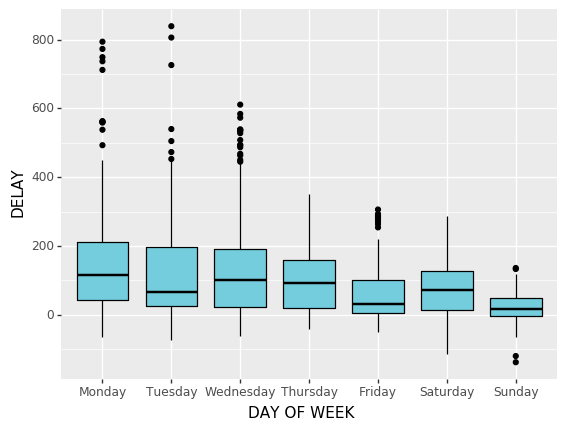

<ggplot: (-9223371921863518544)>

In [35]:
full_week['DAY_OF_WEEK_cat'] = full_week['DAY_OF_WEEK'].astype('category')

plot_box2 = ggplot(full_week, aes(x='DAY_OF_WEEK_cat', y='DELAY')) + \
            geom_boxplot(color='black', fill='#74CDDC') + \
            xlab("DAY OF WEEK") + \
            ylab("DELAY")
plot_box2

In [36]:
days_col = ['#74CDDC' , '#ffffb3','#BBC9DB','#fb8072','#386cb0','#28AE7B','#4DFFA5']

#### Závislost zpoždění se zastávkami v jednotlivých dnech v týdnu

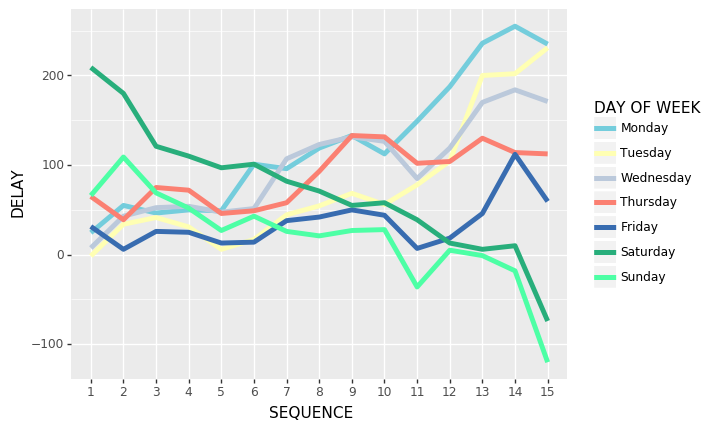

<ggplot: (-9223371921863308012)>


In [37]:
avg_delay_per_day_stop = full_week.groupby(['DAY_OF_WEEK','SEQUENCE'])[['DELAY']].median()
avg_delay_per_day_stop = avg_delay_per_day_stop.reset_index()
plot_week1 = ggplot(avg_delay_per_day_stop, aes(x='SEQUENCE', y='DELAY', color='DAY_OF_WEEK')) +\
            geom_line(size=2) + \
            xlab("SEQUENCE") + \
            ylab("DELAY") + \
            labs(color='DAY OF WEEK') + \
            scale_color_manual(values=days_col) + \
            scale_x_discrete(limits=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))
print(plot_week1)

### **Mann-Whitney U-test**

zdroj: *https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/*

Sobota & Neděle

In [38]:
# generate two independent samples
dataSat = full_week[full_week['DAY_OF_WEEK']=='Saturday']['DELAY']
dataSun = full_week[full_week['DAY_OF_WEEK']=='Sunday']['DELAY']
# compare samples
stat, p = mannwhitneyu(dataSun, dataSat)
print(f'Statistics={stat}, p={p}')
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=570.0, p=0.00011316291843161926
Different distribution (reject H0)


Pátek & Sobota

In [39]:
# generate two independent samples
dataSat = full_week[full_week['DAY_OF_WEEK']=='Saturday']['DELAY']
dataFri = full_week[full_week['DAY_OF_WEEK']=='Friday']['DELAY']
# compare samples
stat, p = mannwhitneyu(dataFri, dataSat)
print(f'Statistics={stat}, p={p}')
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=2040.5, p=0.05103304766638928
Same distribution (fail to reject H0)


Pondělí & Středa + otestování dalších pracovních dnů mezi sebou

In [40]:
# generate two independent samples
dataMon = full_week[full_week['DAY_OF_WEEK']=='Monday']['DELAY']
dataWed = full_week[full_week['DAY_OF_WEEK']=='Wednesday']['DELAY']
# compare samples
stat, p = mannwhitneyu(dataMon, dataWed)
print(f'Statistics={stat}, p={p}')
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=22999.5, p=0.08535362995178641
Same distribution (fail to reject H0)


### **Závěr: stejné rozdělení dat mají dvojice pondělí a středa, úterý a čtvrtek, pátek a sobota a neděle zvlášť**

Interpretace závěru v grafu hustoty rozdělení zpoždění během jednotlivých dnů

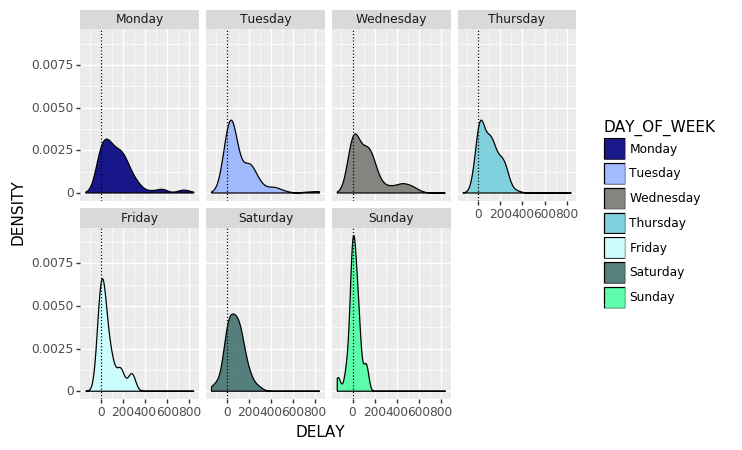

<ggplot: (-9223371921863367264)>

In [41]:
plot_hist3 = ggplot(full_week, aes(x='DELAY', fill='DAY_OF_WEEK')) + \
            geom_density(alpha=.9, color='black') + \
            facet_wrap(['DAY_OF_WEEK'], nrow=2) + \
            geom_vline(xintercept=0,linetype='dotted') + \
            scale_fill_manual(values=['#000080','#98B5FF','#797975','#74CDDC','#C9FFFF','#457371','#4DFFA5']) + \
            xlab("DELAY") + \
            ylab("DENSITY")
plot_hist3

# **Lineární regrese**

In [42]:
data_for_regression = full_week[['DAY_OF_WEEK','DELAY','ORIGIN_TIMESTAMP','SEQUENCE']]

In [43]:
timestamp = pd.to_datetime(data_for_regression['ORIGIN_TIMESTAMP'].astype(str))
seconds = timestamp.dt.second
minutes = timestamp.dt.minute
hours = timestamp.dt.hour

timestamp_seconds = seconds + minutes * 60 + hours * 60 * 60
data_for_regression["TIMESTAMP_SECONDS"] = timestamp_seconds
data_for_regression.drop(columns=["ORIGIN_TIMESTAMP",], inplace=True)

In [44]:
data_for_regression

,DAY_OF_WEEK,DELAY,SEQUENCE,TIMESTAMP_SECONDS
2100,Tuesday,0.0,1,27896
2101,Tuesday,66.0,2,28080
2102,Tuesday,19.0,3,28281
2103,Tuesday,17.0,4,28347
2104,Tuesday,-21.0,5,28375
...,...,...,...,...
5711,Sunday,5.0,12,31568
5712,Sunday,0.0,13,31632
5713,Sunday,-66.0,14,31675
5714,Sunday,-138.0,15,31831


zdroj: *https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html*

Parametry magic

In [45]:
one_hot_dow = OneHotEncoder(drop="first", sparse=False)
one_hot_seq = OneHotEncoder(drop="first", sparse=False)

A_dummies_tmp = one_hot_dow.fit_transform(data_for_regression["DAY_OF_WEEK"].to_numpy().reshape(-1, 1))
A_dummies = pd.DataFrame(A_dummies_tmp, columns=one_hot_dow.get_feature_names()).dropna()

B_dummies_tmp = one_hot_seq.fit_transform(data_for_regression["SEQUENCE"].to_numpy().reshape(-1, 1))
B_dummies = pd.DataFrame(B_dummies_tmp, columns=one_hot_seq.get_feature_names()).dropna()

In [46]:
# Naše stará verze, zdroj: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
# A_dumies = pd.get_dummies(data_for_regression['DAY_OF_WEEK'],drop_first=True).dropna()
# B_dumies = pd.get_dummies(data_for_regression['SEQUENCE'],drop_first=True).dropna()

In [47]:
merged = pd.concat([
    data_for_regression.reset_index(drop=True),
    A_dummies.reset_index(drop=True),
    B_dummies.reset_index(drop=True),
],axis='columns')

In [49]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   DAY_OF_WEEK        978 non-null    category
 1   DELAY              978 non-null    float64 
 2   SEQUENCE           978 non-null    int64   
 3   TIMESTAMP_SECONDS  978 non-null    int64   
 4   x0_Monday          978 non-null    float64 
 5   x0_Saturday        978 non-null    float64 
 6   x0_Sunday          978 non-null    float64 
 7   x0_Thursday        978 non-null    float64 
 8   x0_Tuesday         978 non-null    float64 
 9   x0_Wednesday       978 non-null    float64 
 10  x0_2               978 non-null    float64 
 11  x0_3               978 non-null    float64 
 12  x0_4               978 non-null    float64 
 13  x0_5               978 non-null    float64 
 14  x0_6               978 non-null    float64 
 15  x0_7               978 non-null    float64 
 16  x0_8    

In [50]:
final = merged.drop(['DAY_OF_WEEK','SEQUENCE'],axis='columns')

#### Chceme predikovat Y na základě X

In [51]:
X = final.drop(['DELAY'],axis='columns')

Přidání konstanty (const = 1) z teoretického hlediska (=intercept).

In [52]:
X = sm.add_constant(X)

In [53]:
Y = merged.DELAY

#### Metoda nejmenších čtevrců

zdroj: *https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html?highlight=ols#statsmodels.regression.linear_model.OLS*

In [54]:
sm_model = sm.OLS(Y, X)
sm_result = sm_model.fit()

Přehled 

In [55]:
sm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  DELAY   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     16.80
Date:                Sun, 31 May 2020   Prob (F-statistic):           7.19e-52
Time:                        13:36:25   Log-Likelihood:                -6042.4
No. Observations:                 978   AIC:                         1.213e+04
Df Residuals:                     956   BIC:                         1.224e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -591.5553     71.235     -8.304      0.000    -731.350    -451.761
TIMESTAMP_SECONDS     0.0198      0.002      8.624      0.000       0.015       0.024
x0_Monday            82.7690     13.795      6.000      0.000      55.697     109.841
x0_Saturday          16.1607     20.915      0.773      0.440     -24.883      57.205
x0_Sunday           -39.7629     20.758     -1.916      0.056     -80.500       0.974
x0_Thursday          35.4912     15.812      2.245      0.025       4.462      66.521
x0_Tuesday           55.4007     13.846      4.001      0.000      28.228      82.573
x0_Wednesday         68.4139     13.794      4.960      0.000      41.343      95.484
x0_2                 19.6053     21.052      0.931      0.352     -21.708      60.919
x0_3                 22.9975     21.036      1.093      0.275     -18.284      64.279
x0_4                 18.3723     21.034      0.873      0.383     -22.906      59.651
x0_5                  1.0353     21.121      0.049      0.961     -40.414      42.485
x0_6                 20.3842     21.121      0.965      0.335     -21.064      61.832
x0_7                 41.6059     20.641      2.016      0.044       1.098      82.114
x0_8                 68.4581     21.063      3.250      0.001      27.123     109.793
x0_9                 78.2277     20.976      3.729      0.000      37.064     119.391
x0_10                65.6722     20.971      3.132      0.002      24.518     106.826
x0_11                74.3964     20.804      3.576      0.000      33.570     115.222
x0_12               102.8666     20.442      5.032      0.000      62.751     142.982
x0_13               153.3889     20.310      7.552      0.000     113.531     193.247
x0_14               165.3260     20.184      8.191      0.000     125.717     204.935
x0_15               160.4141     20.463      7.839      0.000     120.257     200.571
==============================================================================
Omnibus:                      245.663   Durbin-Watson:                   0.426
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              697.199
Skew:                           1.261   Prob(JB):                    4.03e-152
Kurtosis:                       6.278   Cond. No.                     5.87e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Fitování modelu

In [56]:
model = LinearRegression()

In [57]:
model.fit(X.drop(columns="const"), Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
model.coef_

array([ 1.98052282e-02,  8.27690426e+01,  1.61607046e+01, -3.97628671e+01,
        3.54912499e+01,  5.54007061e+01,  6.84139499e+01,  1.96053389e+01,
        2.29975278e+01,  1.83723165e+01,  1.03532262e+00,  2.03841754e+01,
        4.16058980e+01,  6.84581019e+01,  7.82277019e+01,  6.56721603e+01,
        7.43963946e+01,  1.02866564e+02,  1.53388904e+02,  1.65325975e+02,
        1.60414099e+02])

In [59]:
data_for_regression.head()

,DAY_OF_WEEK,DELAY,SEQUENCE,TIMESTAMP_SECONDS
2100,Tuesday,0.0,1,27896
2101,Tuesday,66.0,2,28080
2102,Tuesday,19.0,3,28281
2103,Tuesday,17.0,4,28347
2104,Tuesday,-21.0,5,28375


#### Predikce

In [127]:
data_for_prediction = pd.DataFrame({
    "DAY_OF_WEEK": ["Tuesday"],
    "SEQUENCE": [13],
    "TIMESTAMP_SECONDS": [28000],
})

In [128]:
A_dummies_tmp = one_hot_dow.transform(data_for_prediction["DAY_OF_WEEK"].to_numpy().reshape(-1, 1))
A_dummies = pd.DataFrame(A_dummies_tmp, columns=one_hot_dow.get_feature_names()).dropna()

B_dummies_tmp = one_hot_seq.transform(data_for_prediction["SEQUENCE"].to_numpy().reshape(-1, 1))
B_dummies = pd.DataFrame(B_dummies_tmp, columns=one_hot_seq.get_feature_names()).dropna()

In [129]:
merged = pd.concat([
    data_for_prediction.reset_index(drop=True),
    A_dummies.reset_index(drop=True),
    B_dummies.reset_index(drop=True),
],axis='columns')

final = merged.drop(['DAY_OF_WEEK','SEQUENCE'],axis='columns')

In [130]:
final

,TIMESTAMP_SECONDS,x0_Monday,x0_Saturday,x0_Sunday,x0_Thursday,x0_Tuesday,x0_Wednesday,x0_2,x0_3,x0_4,...,x0_6,x0_7,x0_8,x0_9,x0_10,x0_11,x0_12,x0_13,x0_14,x0_15
0,28000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [131]:
model.predict(final)

array([171.7806759])

# **Graf porovnání zpožděných a nezpožděných autobusů během pracovního týdne během zkoumaného čas. období (7:30-9)**

In [97]:
delay_2minutes = bebe[ (bebe['DELAY']>=120) & (bebe['DELAY']<300) ]
delay_5minutes = bebe[bebe['DELAY']>=300]
delay_nope = bebe[bebe['DELAY']<120]

In [98]:
delay_2 = delay_2minutes.groupby('DAY_OF_WEEK')['DELAY'].count()
delay_5 = delay_5minutes.groupby('DAY_OF_WEEK')['DELAY'].count()
at_time = delay_nope.groupby('DAY_OF_WEEK')['DELAY'].count()

In [99]:
index = ['Monday', 'Tuesday', 'Wednesday',
         'Thursday', 'Friday']
df_barplot = pd.DataFrame({
    'AT TIME': at_time,
    '2-5 MIN': delay_2,
    'MORE THAN 5 MIN':delay_5
}, index=index) 

In [105]:
m = pd.melt(df_barplot.reset_index(), id_vars=['index'])

In [106]:
m

,index,variable,value
0,Monday,AT TIME,118
1,Tuesday,AT TIME,138
2,Wednesday,AT TIME,122
3,Thursday,AT TIME,71
4,Friday,AT TIME,86
5,Monday,2-5 MIN,80
6,Tuesday,2-5 MIN,61
7,Wednesday,2-5 MIN,70
8,Thursday,2-5 MIN,42
9,Friday,2-5 MIN,22


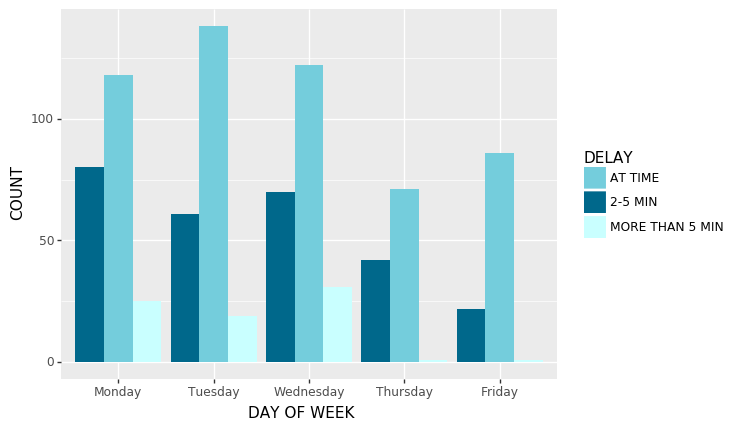

<ggplot: (-9223371921863316968)>

In [120]:
barplot = ggplot(m, aes(x = "index", y="value")) + \
                    xlab("DAY OF WEEK") + \
                    ylab("COUNT") + \
                    geom_bar(aes(fill = "variable"),stat = "identity", position = "dodge") + \
                    scale_fill_manual(values=['#00688B','#74CDDC', '#C9FFFF'],breaks=("AT TIME","2-5 MIN","MORE THAN 5 MIN")) + \
                    labs(fill = "DELAY") + \
                    scale_x_discrete(limits=index)
barplot